In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.ensemble import IsolationForest

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [208]:
data=pd.read_csv('/content/drive/MyDrive/2023-2/credit_risk_dataset.csv')

In [209]:
#Leemos la data
print(data.shape)
data.head(10)

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


In [210]:
data.describe()
#Aquí podemos ver que no tenemos columnas con un único valor, pues todas tienen una desviacion estandar diferente de 0

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Tratamiento de missing values

In [212]:
data.info()
#Aquí podemos ver que tendremos missing values en las variables person_emp_length y en loan_int_rate
#Según el diccionarios, estas variables son la duracion de su tiempo como empleado, en término prácticos, cuanto tiempo
#ha mantenido un ingreso continuado (o años trabajando) y la otra es la tasa de interés.
#Ambas variables son fundamentales para poder modelar el riesgo del crédito.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [213]:
for col in data.columns:
        pct_missing = np.mean(data[col].isnull())
        print('{}-{}'.format(col, pct_missing))
#Aquí podemos ver el porcentaje de missings que tenemos que cada variable, en person_emp_lenght es cercano al 3%
#Mientras que en loan_int_rate es cercano al 10%

person_age-0.0
person_income-0.0
person_home_ownership-0.0
person_emp_length-0.027469997851508547
loan_intent-0.0
loan_grade-0.0
loan_amnt-0.0
loan_int_rate-0.0956385623522912
loan_status-0.0
loan_percent_income-0.0
cb_person_default_on_file-0.0
cb_person_cred_hist_length-0.0


In [214]:
for col in data.columns:
        pct_missing = np.sum(data[col].isnull())
        print('{}-{}'.format(col, pct_missing))
#Aquí podemos ver más exactamente que para person_emp_length tenemos 895 missing values
#Y para lan_int_rate 3116

person_age-0
person_income-0
person_home_ownership-0
person_emp_length-895
loan_intent-0
loan_grade-0
loan_amnt-0
loan_int_rate-3116
loan_status-0
loan_percent_income-0
cb_person_default_on_file-0
cb_person_cred_hist_length-0


In [215]:
#En este caso tenemos dos caminos a seguir: dropear los missing values o estimarlos con alguna técnica
#Para decidir, debemos pensar en qué factores se utilizan para estimar la probabilidad de default y también pensar en cómo funciona el bussines
#Si nos detenemos un poco, en la vida real, cuando solicitamos un préstamo, siempre nos preguntan cuánto tiempo llevamos trabajando.
#Para el banco eso es importante, porque es como una garantía de que tendremos un flujo de ingresos fijo y podremos pagarles
#En ese sentido, dropear esos datos no sería lo ideal, pues es información valiosa que luego insumaré en el modelo
#En el caso de la tasa de interés, sucede lo mismo, pues la probabilidad de default también se encuentra en relación a cuánto más pagaré sobre la deuda capital
#Además, no tengo muchos datos, no puedo darme el lujo de eliminar 4000 datos aproximadamente
#Decidí, entonces, estimar los missing values

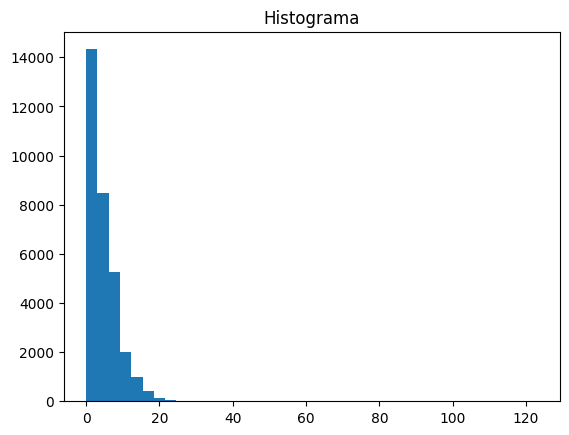

In [216]:
#Ahora tenemos que decidir con qué rellenaremos los missing values
#Para ello, reviseremos la distribución de los datos

#Para person_emp_length
plt.hist(data['person_emp_length'], bins=40)
plt.title("Histograma")
plt.show()

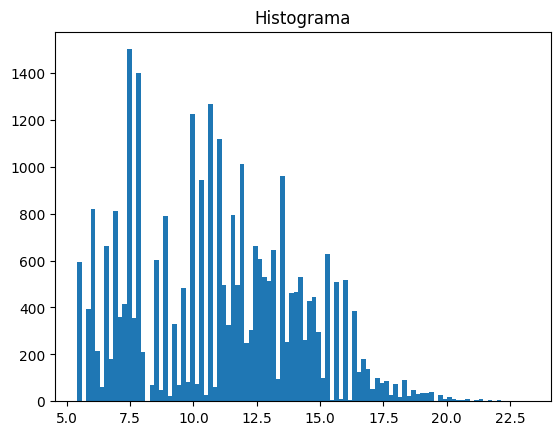

In [217]:
#Para loan_int_rate
plt.hist(data['loan_int_rate'], bins=100)
plt.title("Histograma")
plt.show()

In [ ]:
#Como podemos ver, en ambos casos, los datos están desbalanceados, tirados hacia la izquierda del gráfico

## Para la variable person_emp_length

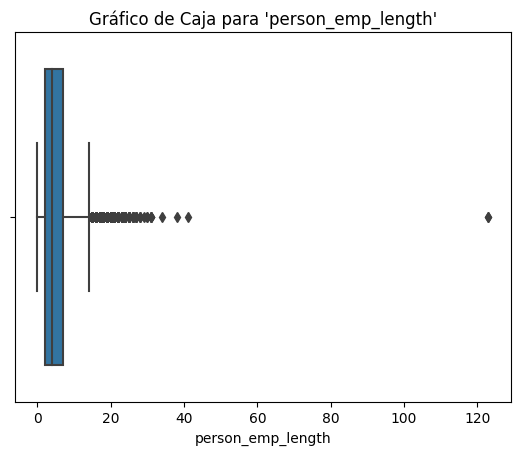

In [218]:
#Para imputar nuestros missings vamos a segmentar nuestra data. A cada missing de cada segmento se le asignará la media de su segmento correspondiente.
#Nos servirá un gráfico de cajas, para ver mejor los outliers:
sns.boxplot(x='person_emp_length', data=data)
plt.title("Gráfico de Caja para 'person_emp_length'")
plt.show()


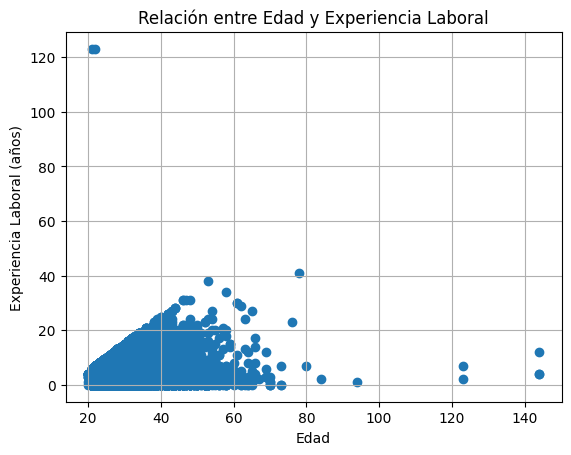

In [219]:
#Aquí podemos ver que hay outliers, con años trabajando que superan los 100 años.
#Estos datos atípicos se tratarán más adelante.
#Continuando con la segmentación, debemos preguntarnos ¿a partir de qué característica voy a segmentar?
#Un camino sencillo podría ser por el tipo de préstamo -loan_intent- pero no me termina de convencer
#Algo más lógico sería por la edad, pues con la edad, aumentan los años de experiencia laboral
#Veamos un gráfico:
plt.scatter(data['person_age'], data['person_emp_length'])
plt.xlabel('Edad')
plt.ylabel('Experiencia Laboral (años)')
plt.title('Relación entre Edad y Experiencia Laboral')
plt.grid(True)
plt.show()

In [110]:
#Lo ideal sería entonces, poder segmentarlos por rangos de edad
#Ahora, como podemos observar, la mayoría de datos se encuentra por debajo de los 70 años, de modo que la segmentación será hasta esa edad


In [221]:
def age_range(person_age):
    if person_age >= 20 and person_age < 30:
        return '20'
    elif person_age >= 30 and person_age < 40:
        return '30'
    elif person_age >= 40 and person_age < 50:
        return '40'
    elif person_age >= 50 and person_age < 60:
        return '50'
    elif person_age >= 60 and person_age < 70:
        return '60'
    elif person_age >= 70:
        return '70+'
    else:
        return '70+'

# Crea una nueva columna 'rango_edad' usando la función
data['age_range'] = data['person_age'].apply(age_range)
data.head(100)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_range
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,20
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,20
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,20
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,20
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,20
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2,20
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3,20
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4,20
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2,20
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3,20


In [222]:
medias_por_age_range = data.groupby('age_range')['person_emp_length'].transform('mean')

# Llena los missing values de 'person_emp_length' con las medias por rango de edad
data['person_emp_length'].fillna(medias_por_age_range, inplace=True)


In [205]:
data['person_emp_length'].unique()

array([ 5.        ,  1.        ,  4.        ,  8.        ,  2.        ,
        6.        ,  7.        ,  0.        ,  3.        , 10.        ,
        9.        ,  4.41707861, 18.        ,  5.6652125 , 17.        ,
       14.        , 11.        , 12.        , 16.        , 13.        ,
       19.        , 15.        , 20.        , 22.        ,  6.22366522,
       21.        , 24.        , 23.        ,  5.70916335, 26.        ,
       25.        , 27.        , 28.        , 31.        , 41.        ,
        6.05263158, 34.        , 29.        , 30.        ])

In [223]:
for col in data.columns:
        pct_missing = np.sum(data[col].isnull())
        print('{}-{}'.format(col, pct_missing))
#Ahora vemos que para person_emp_length ya no tenemos missing values, han sido rellenadas con las medias de sus grupos de edad

person_age-0
person_income-0
person_home_ownership-0
person_emp_length-0
loan_intent-0
loan_grade-0
loan_amnt-0
loan_int_rate-3116
loan_status-0
loan_percent_income-0
cb_person_default_on_file-0
cb_person_cred_hist_length-0
age_range-0


## Para la variable loan_int_rate

<ipython-input-224-69f5b0d3e2e0>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


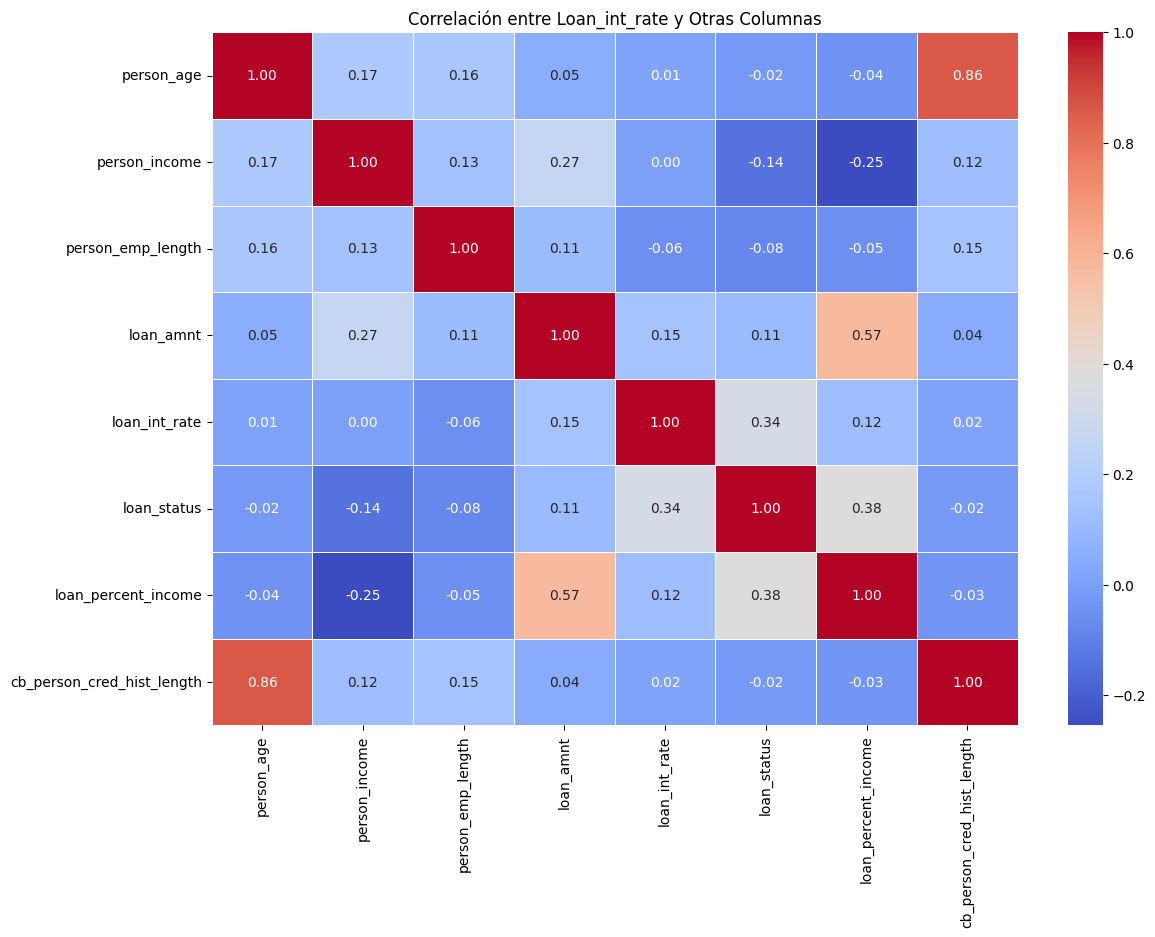

In [224]:
#Para proceder más rápidamente con esta variable, lo que hice fue plotear un mapa de calor con todas las variables numéricas
#De esta manera podría darme cuenta si tenían algún tipo correlación.
#Sin embargo, como se observa, la variable loan_int_rate no tiene una correlacion fuerte con ninguna variable numérica
correlation_matrix = data.corr()
plt.figure(figsize=(13, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlación entre Loan_int_rate y Otras Columnas")
plt.show()

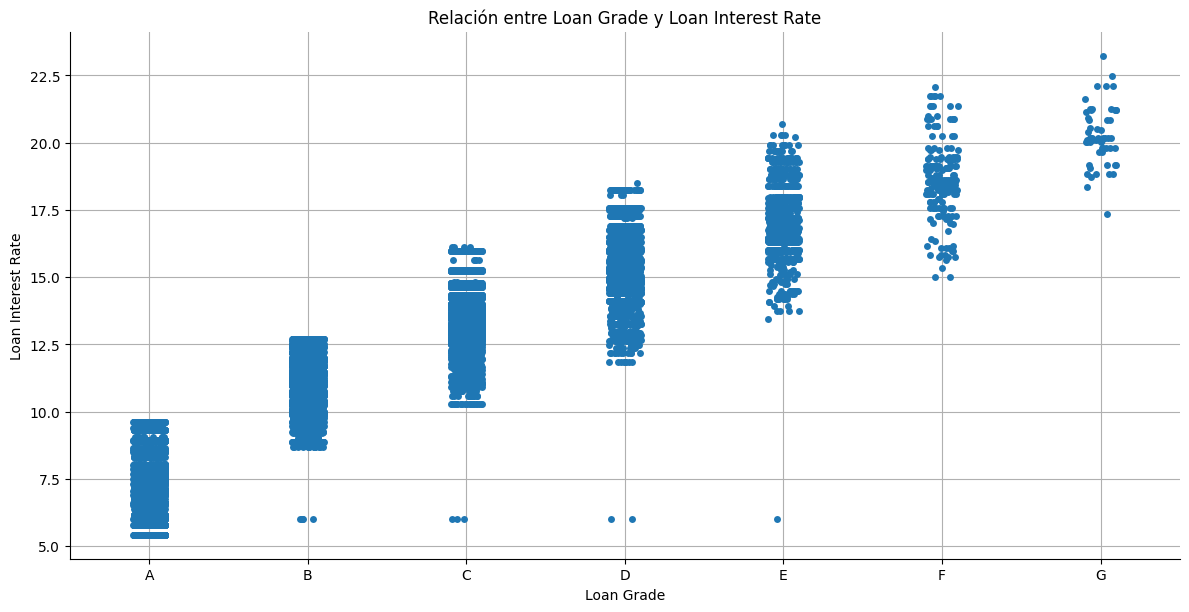

In [225]:
#De modo que solo nos quedaba probar con variables categóricas y la más idónea me pareció la loan_grade
#Pues tiene mucho sentido que, a mejor rating o nota, te apliquen una tasa de interés más baja y viceversa
sns.catplot(x='loan_grade', y='loan_int_rate', data=data, kind='strip', height=6, aspect=2, order=sorted(data['loan_grade'].unique()))
plt.xlabel('Loan Grade')
plt.ylabel('Loan Interest Rate')
plt.title('Relación entre Loan Grade y Loan Interest Rate')
plt.grid(True)
plt.show()

In [20]:
#En el gráfico anterior se puede observar que mientras peor sea tu loan_grade, más alta será tu tasa de interés
#Incluso, para el grade G, son pocos los que reciben préstamos.

In [226]:
#Ahora sí podemos rellenar los missings con las medias de las tasas de interés de cada categoría de la variable loan_grade
medias_por_loan_grade = data.groupby('loan_grade')['loan_int_rate'].transform('mean')

# Llena los missing values de 'person_emp_length' con las medias por rango de edad
data['loan_int_rate'].fillna(medias_por_loan_grade, inplace=True)
data.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_range
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,20
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,20
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,20
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,20
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,20


In [227]:
for col in data.columns:
        pct_missing = np.sum(data[col].isnull())
        print('{}-{}'.format(col, pct_missing))
#Ahora vemos que ya no hay ningún missing value para ninguna variable

person_age-0
person_income-0
person_home_ownership-0
person_emp_length-0
loan_intent-0
loan_grade-0
loan_amnt-0
loan_int_rate-0
loan_status-0
loan_percent_income-0
cb_person_default_on_file-0
cb_person_cred_hist_length-0
age_range-0


# Tratamiento de outliers

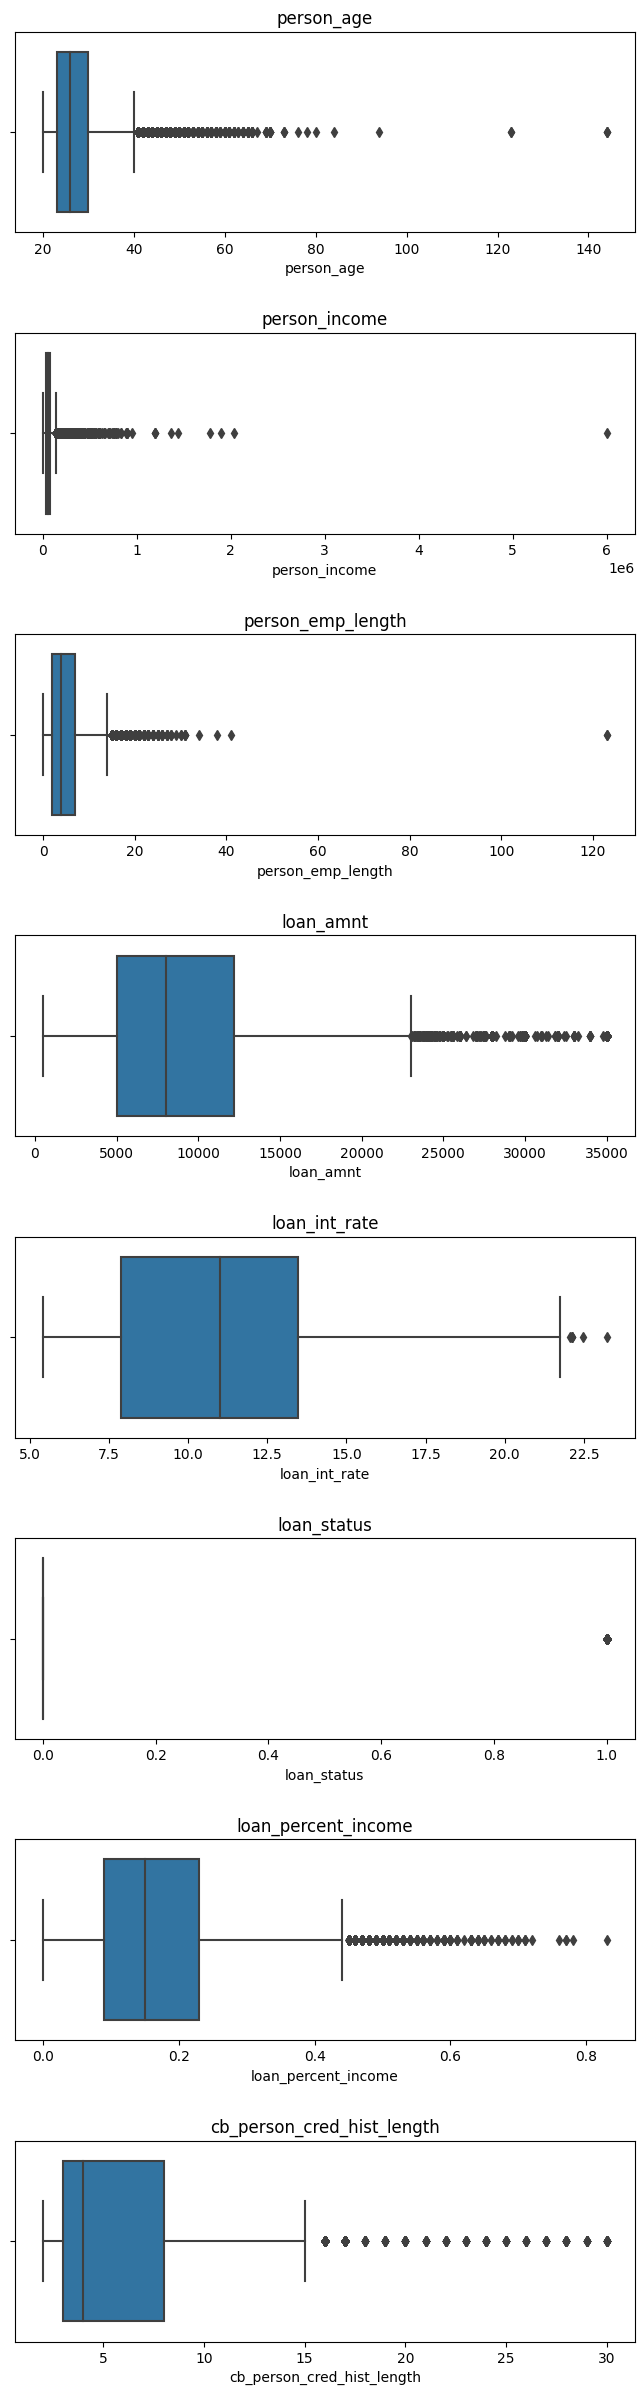

In [228]:
#Ahora vamos a generar gráficas para las variables numericas para poder identificar los valores extremos o outliers

cols_num = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(8,30))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=data, ax=ax[i])
    ax[i].set_title(col)

In [ ]:
#La primera intervención sobre los outliers la podemos hacer sobre las variables edad y años trabajando (person_age y person_emp_length)

In [229]:
#Aquí eliminaremos todos los datos que tengan una edad mayor a 100
print(f'Data antes de eliminar edades mayores a 100: {data.shape}')
data = data[data['person_age']<=100]
print(f'Data después de eliminar edades mayores a 100: {data.shape}')
#Se eliminaron 5 datos

Data antes de eliminar edades mayores a 100: (32581, 13)
Data después de eliminar edades mayores a 100: (32576, 13)


In [230]:
#Aquí eliminaremos todos los datos que tengan una cantidad de años trabajando mayor a 70
print(f'Data antes de eliminar personas con más de 70 años trabajando: {data.shape}')
data = data[data['person_emp_length']<=70]
print(f'Data después de eliminar personas con más de 70 años trabajando: {data.shape}')
#Se eliminaron 2 datos

Data antes de eliminar personas con más de 70 años trabajando: (32576, 13)
Data después de eliminar personas con más de 70 años trabajando: (32574, 13)


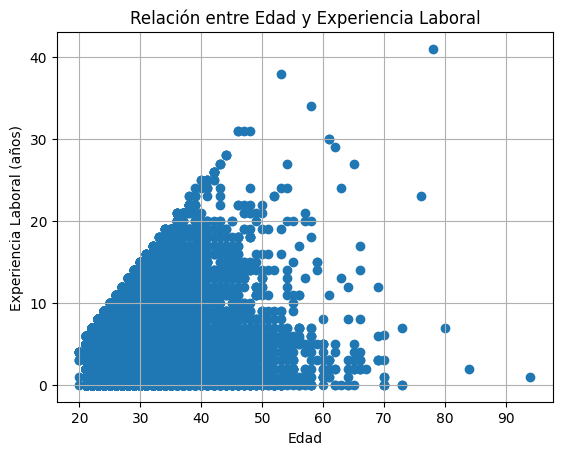

In [231]:
#Revisemos nuevamente la relación entre edad y experiencia laboral
plt.scatter(data['person_age'], data['person_emp_length'])
plt.xlabel('Edad')
plt.ylabel('Experiencia Laboral (años)')
plt.title('Relación entre Edad y Experiencia Laboral')
plt.grid(True)
plt.show()

#Como se puede observar, siguen habiendo valores raros, como, por ejemplo personas de más de 70 años con 0 años de experiencia laboral

In [232]:
#Lo que haremos entonces es que vamos a eliminar los datos no cumplan la siguiente regla:
#Su experiencia laboral no puede ser mayor a su edad menos 16 años.
#Por qué 16, pues porque en USA puedes empezar a trabajar desde esa edad con el permiso legal de tus padres.
print(f'Data antes de eliminar observaciones no lógicas: {data.shape}')
data = data[data['person_emp_length'] <= (data['person_age'] - 16)]
print(f'Data después de eliminar observaciones no lógicas: {data.shape}')
#Se eliminaron 738 datos

Data antes de eliminar observaciones no lógicas: (32574, 13)
Data después de eliminar observaciones no lógicas: (31836, 13)


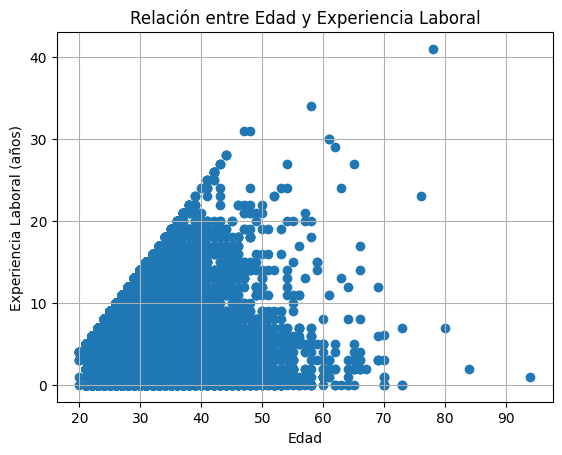

In [233]:
#Revisemos nuevamente la relación entre edad y experiencia laboral
plt.scatter(data['person_age'], data['person_emp_length'])
plt.xlabel('Edad')
plt.ylabel('Experiencia Laboral (años)')
plt.title('Relación entre Edad y Experiencia Laboral')
plt.grid(True)
plt.show()
#Siguen apareciendo datos raros

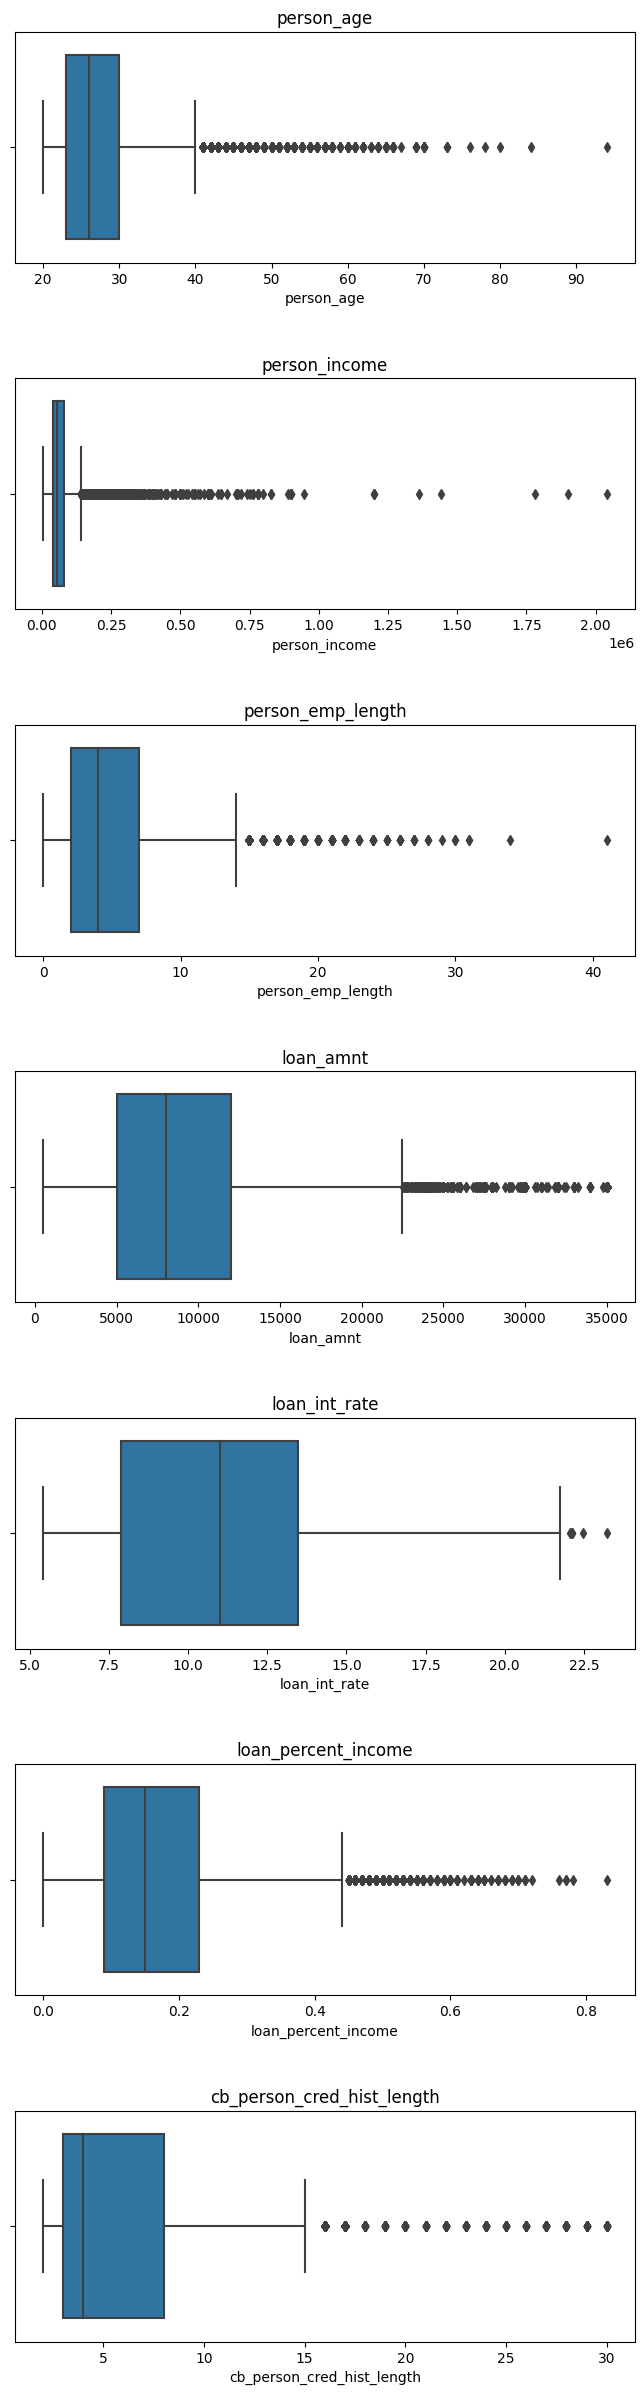

In [234]:
#Revisamos nuevamente nuestros datos con gráficos de cajas
cols_num = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(8,30))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=data, ax=ax[i])
    ax[i].set_title(col)

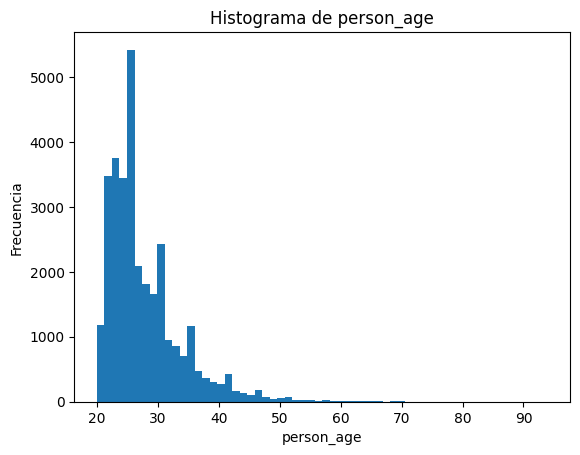

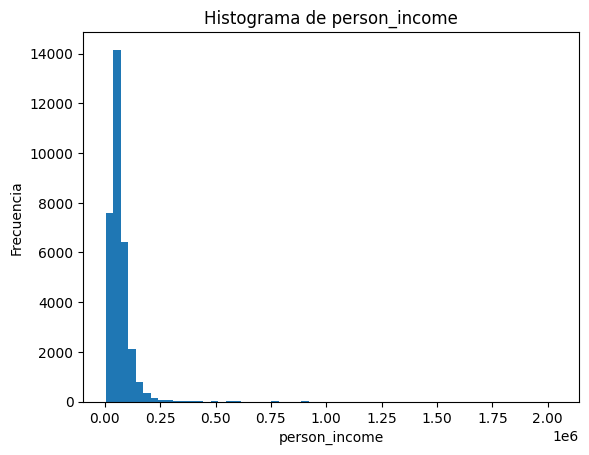

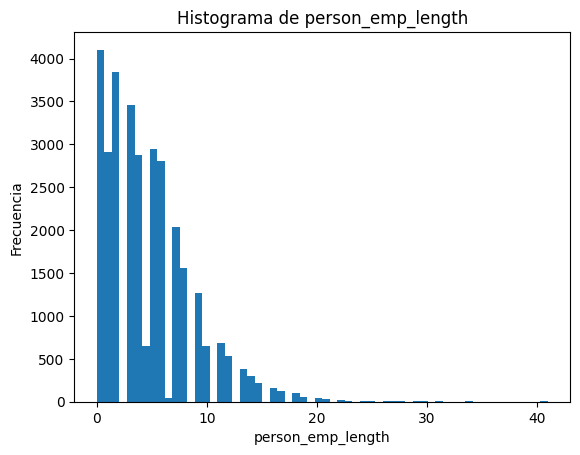

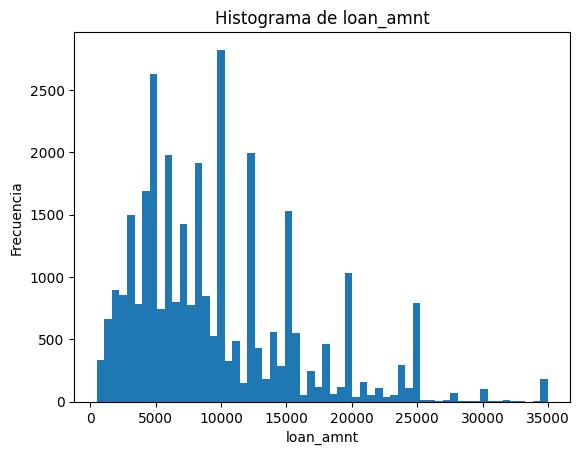

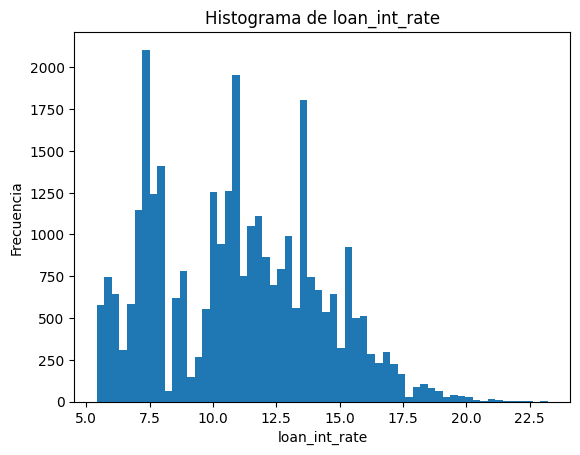

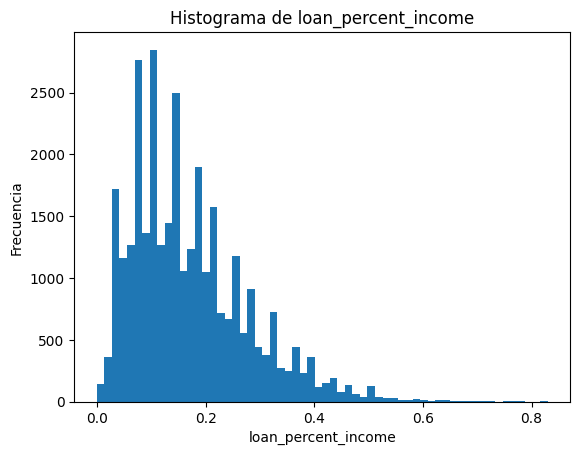

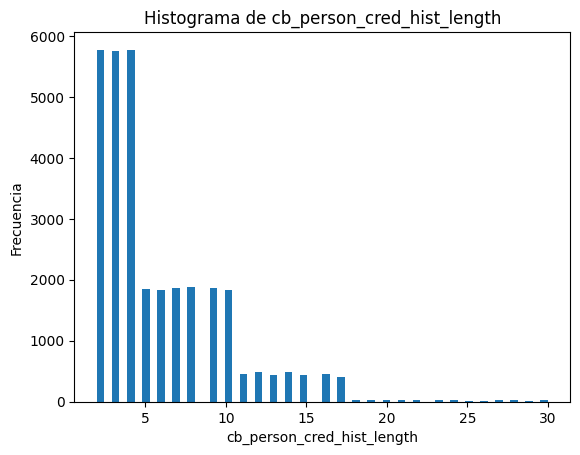

In [235]:
cols_num = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

for col in cols_num:
    plt.hist(data[col], bins=60)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

In [ ]:
#En este punto nos tenemos que detener a pensar en la lógica de cada variable

#EDAD: Para esta variable no es necesario eliminar observaciones de edades que sean mayores a 80 o 90. La razón: es ilegal en EEUU utilizar modelos que afecten a las personas mayores a los 62 años.
  #Entonces, como la mayoría de nuestra data está concentrada en edades de 20 a 40 años, no tendríamos por qué tocarla nuevamente.
#INGESOS: La mayoría tiene un ingreso entre 0 y 25 mil dólares al año. Hay pocas personas que ganen más de 100 mil dólares al año. Tiene sentido porque nuestra data está llena de jóvenes.
#AÑOS_TRABAJANDO: Sucede de igual forma que con los ingresos, la razón: la mayoría de nuestra población es jóven.
#LOAN_AMOUNT: Para esta variable podemos observar que tiene varios picos, aunque pudiera correlacionarse con el tipo de préstamo o el score. Podría considerarse el suavizamiento también.
  #De todas formas se analizará más a fondo esta variable.
#INT_RATE: La tasa de interés también tiene un comportamiento similar al de Loan Amount, por lo que también se le tomará más atención.
#LOAN_PERCENT_INCOME: Esta variable también tiene picos por lo que merece también tratamiento profundo.
#CRED_HIST_LEN: Esta variable, aunque parece tener un comportamiento de variable categórica, pues está bien segmentada, sigue un comportamiento acorde con los datos de edad y años trabajando.
  #La mayoría tiene un reccord menor a 5 años, pues son jóvenes la mayoría y tienen pocos años trabajando

In [ ]:
#De modo que el tratamiento de outliers más profundo se realizará sobre las siguientes variables: loan_int_rate, loan_percent_income y loan_amount

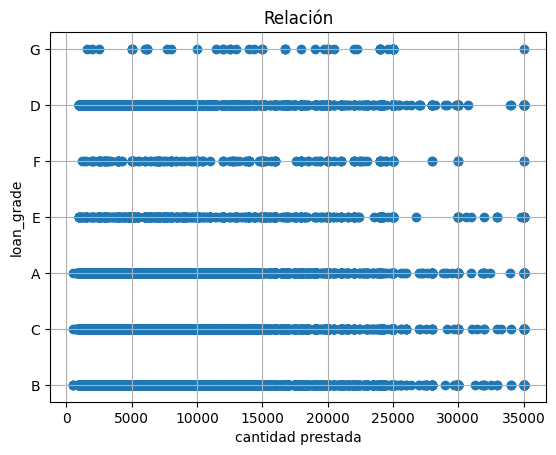

In [139]:
#Veamos la relación entre loan_amount y loan_grade
plt.scatter(data['loan_amnt'], data['loan_grade'])
plt.xlabel('cantidad prestada')
plt.ylabel('loan_grade')
plt.title('Relación')
plt.grid(True)
plt.show()

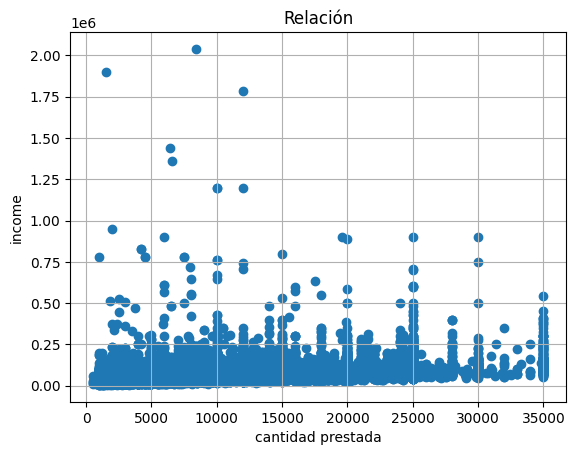

In [236]:
#Veamos la relación entre loan_amount e income
plt.scatter(data['loan_amnt'], data['person_income'])
plt.xlabel('cantidad prestada')
plt.ylabel('income')
plt.title('Relación')
plt.grid(True)
plt.show()

In [ ]:
#En el primer gráfico anterior podemos ver que conforme empeora el loan_grade, la cantidad prestada es menor, a excepción de algunos casos raros.
#En el segundo podemos observar que el nivel de ingresos no es indicador para acceder para acceder al crédito, puedes tener un nivel de ingresos altos, pero solo tener un crédito bajo y lo contrario también.
#El primer gráfico nos es más últi, pues podremos eliminar los casos raros en que el loan_grade es muy bajo y el crédito es altísimo

In [ ]:
#Aplicaremos el siguiente filtro: para las categorías D, E, F y G, eliminaremos las observaciones que tengan un loan_amnt mayor a 30 mil

In [237]:
print(f'Data antes de eliminar observaciones: {data.shape}')
data = data[~((data['loan_grade'].isin(['D', 'E', 'F', 'G'])) & (data['loan_amnt'] > 30000))]
print(f'Data después de eliminar observaciones: {data.shape}')

Data antes de eliminar observaciones: (31836, 13)
Data después de eliminar observaciones: (31771, 13)


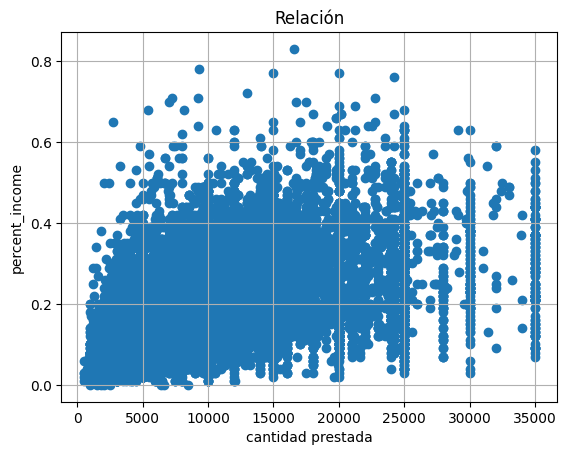

In [148]:
#Por último veremos la relación entre loan_amount y percent_income
plt.scatter(data['loan_amnt'], data['loan_percent_income'])
plt.xlabel('cantidad prestada')
plt.ylabel('percent_income')
plt.title('Relación')
plt.grid(True)
plt.show()

In [238]:
#En este caso podemos ver que la mayoría de los préstamos no sobre pasan el 50% del valor de ingreso de las personas. Incluso para prestamos de 35 mil, el porcentaje máximo es de 60%
#Por ello, resulta raro que se hayan dado préstamos menores a 5 mil que signifique más de 60% del ingreso.
#Se aplicará el siguiente filtro:
print(f'Data antes de eliminar observaciones: {data.shape}')
data = data[data['loan_percent_income'] < 0.6]
print(f'Data después de eliminar observaciones: {data.shape}')

Data antes de eliminar observaciones: (31771, 13)
Data después de eliminar observaciones: (31710, 13)


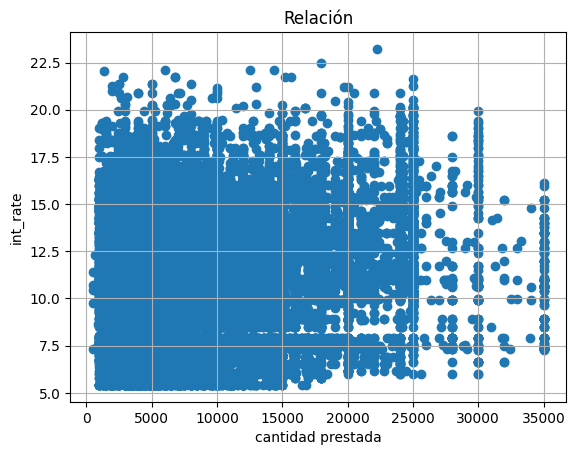

In [149]:
#Por último veremos la relación entre loan_amount y loan_int_rate
plt.scatter(data['loan_amnt'], data['loan_int_rate'])
plt.xlabel('cantidad prestada')
plt.ylabel('int_rate')
plt.title('Relación')
plt.grid(True)
plt.show()

In [ ]:
#Aquí tiene sentido que mientras más bajo sea el préstamo, mayor sea su tasa y que mientras mayor sea la cantidad prestada, la tasa sea baja. No la toco

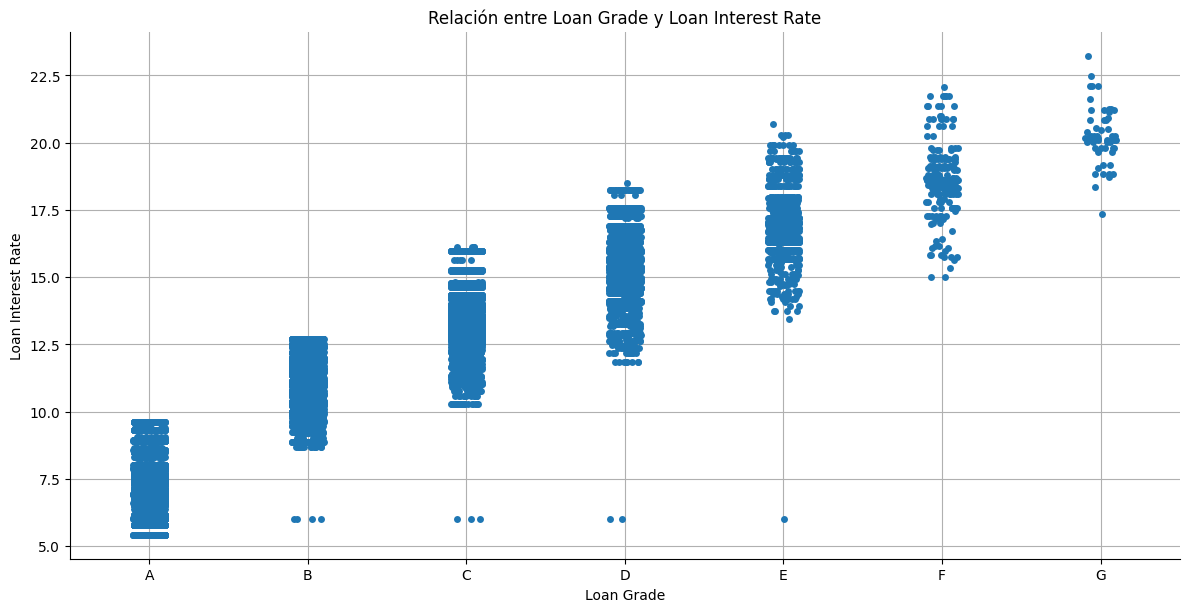

In [239]:
#Veamos nuevamente la relación entre loan_grade y loan_int_rate:
sns.catplot(x='loan_grade', y='loan_int_rate', data=data, kind='strip', height=6, aspect=2, order=sorted(data['loan_grade'].unique()))
plt.xlabel('Loan Grade')
plt.ylabel('Loan Interest Rate')
plt.title('Relación entre Loan Grade y Loan Interest Rate')
plt.grid(True)
plt.show()

In [240]:
#Podemos ver que hay tasas de interés muy bajas para loan_grades deteriorados como los de C, D y E.
#Para mejorar la data entrante, se eliminarán las tasas menores a 7.5 en las categorías B, C, D y E. Asumiendo una postura conservadora.
print(f'Data antes de eliminar observaciones: {data.shape}')
data = data[~((data['loan_grade'].isin(['B', 'C', 'D', 'E'])) & (data['loan_int_rate'] < 7.5))]
print(f'Data después de eliminar observaciones: {data.shape}')

Data antes de eliminar observaciones: (31710, 13)
Data después de eliminar observaciones: (31700, 13)


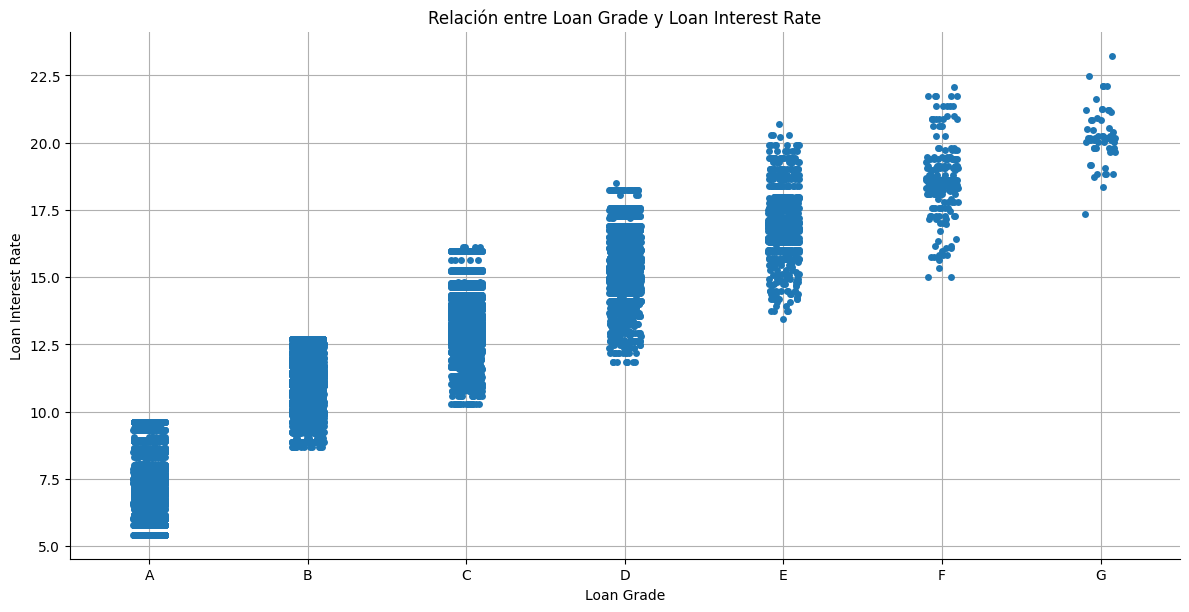

In [241]:
#Veamos nuevamente la relación entre loan_grade y loan_int_rate:
sns.catplot(x='loan_grade', y='loan_int_rate', data=data, kind='strip', height=6, aspect=2, order=sorted(data['loan_grade'].unique()))
plt.xlabel('Loan Grade')
plt.ylabel('Loan Interest Rate')
plt.title('Relación entre Loan Grade y Loan Interest Rate')
plt.grid(True)
plt.show()

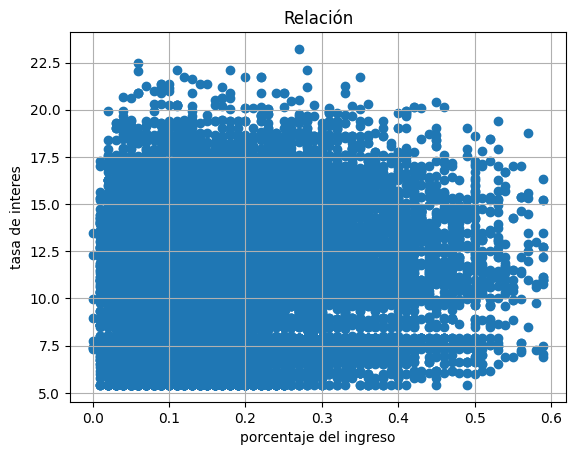

In [242]:
plt.scatter(data['loan_percent_income'], data['loan_int_rate'])
plt.xlabel('porcentaje del ingreso')
plt.ylabel('tasa de interes')
plt.title('Relación')
plt.grid(True)
plt.show()

In [ ]:
#No observo una tendencia clara, por lo que no podría discernir entre un valor atípico o no

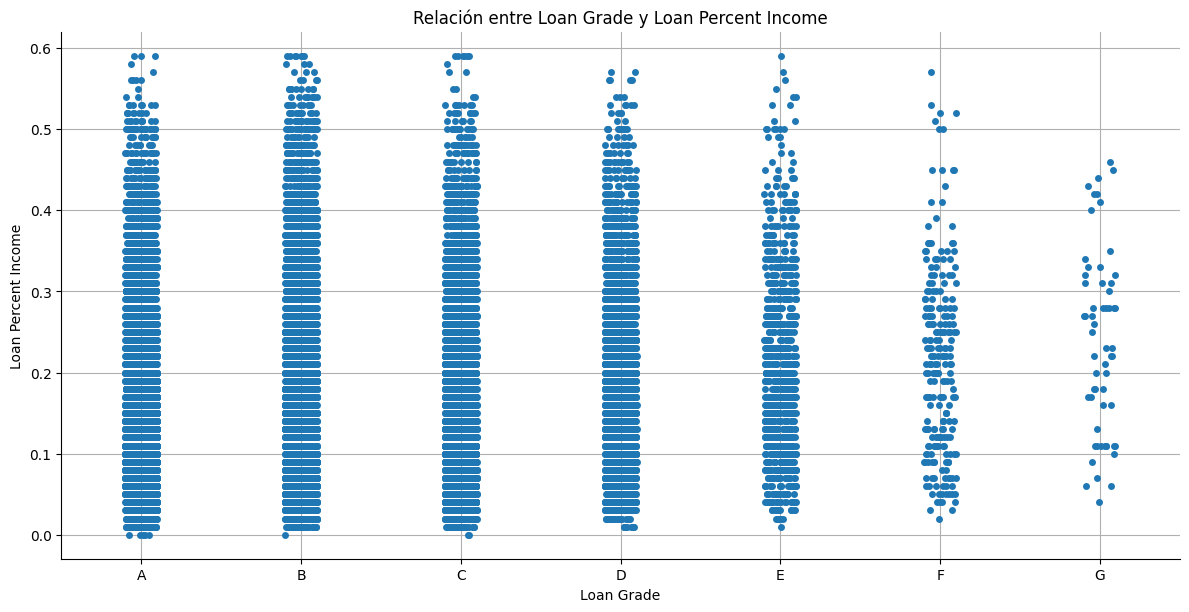

In [243]:
sns.catplot(x='loan_grade', y='loan_percent_income', data=data, kind='strip', height=6, aspect=2, order=sorted(data['loan_grade'].unique()))
plt.xlabel('Loan Grade')
plt.ylabel('Loan Percent Income')
plt.title('Relación entre Loan Grade y Loan Percent Income')
plt.grid(True)
plt.show()

In [ ]:
#El último gráfico solo nos permite ver que a peor nota, menos prestamos. Sin embargo, el percent income es muy fluctuante para todas las categorías de loan_grade.
#No se pueden distinguir valores atípicos.

In [244]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31700 entries, 1 to 32580
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  31700 non-null  int64  
 1   person_income               31700 non-null  int64  
 2   person_home_ownership       31700 non-null  object 
 3   person_emp_length           31700 non-null  float64
 4   loan_intent                 31700 non-null  object 
 5   loan_grade                  31700 non-null  object 
 6   loan_amnt                   31700 non-null  int64  
 7   loan_int_rate               31700 non-null  float64
 8   loan_status                 31700 non-null  int64  
 9   loan_percent_income         31700 non-null  float64
 10  cb_person_default_on_file   31700 non-null  object 
 11  cb_person_cred_hist_length  31700 non-null  int64  
 12  age_range                   31700 non-null  object 
dtypes: float64(3), int64(5), object

In [245]:
data = pd.get_dummies(data, columns=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file'], drop_first=True)
data.head(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,age_range,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,20,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,25,9600,1.0,5500,12.87,1,0.57,3,20,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,2,20,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
4,24,54400,8.0,35000,14.27,1,0.55,4,20,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,20,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [246]:
data = data.drop(columns=['age_range'])
#Borramos age_range

Corriendo el modelo Logit

In [247]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, roc_auc_score, confusion_matrix,
    precision_recall_curve, f1_score, mean_squared_error
)
import statsmodels.api as sm
from scipy import stats

In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31700 entries, 1 to 32580
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   31700 non-null  int64  
 1   person_income                31700 non-null  int64  
 2   person_emp_length            31700 non-null  float64
 3   loan_amnt                    31700 non-null  int64  
 4   loan_int_rate                31700 non-null  float64
 5   loan_status                  31700 non-null  int64  
 6   loan_percent_income          31700 non-null  float64
 7   cb_person_cred_hist_length   31700 non-null  int64  
 8   person_home_ownership_OTHER  31700 non-null  uint8  
 9   person_home_ownership_OWN    31700 non-null  uint8  
 10  person_home_ownership_RENT   31700 non-null  uint8  
 11  loan_intent_EDUCATION        31700 non-null  uint8  
 12  loan_intent_HOMEIMPROVEMENT  31700 non-null  uint8  
 13  loan_intent_MEDI

In [255]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [256]:
X_train = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train)
results = logit_model.fit()

coeficientes = results.params
errores_estandar = results.bse

z_scores = coeficientes / errores_estandar
p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in z_scores]

resultados_df = pd.DataFrame({'Coeficientes': coeficientes, 'Errores_Estandar': errores_estandar, 'P-Values': p_values})
print(resultados_df)

Optimization terminated successfully.
         Current function value: 0.336891
         Iterations 8
                             Coeficientes  Errores_Estandar      P-Values
const                           -4.135875      2.226802e-01  0.000000e+00
person_age                      -0.005531      6.668908e-03  4.069156e-01
person_income                    0.000002      5.706836e-07  1.427606e-03
person_emp_length               -0.016442      5.583713e-03  3.233829e-03
loan_amnt                       -0.000121      5.268586e-06  0.000000e+00
loan_int_rate                    0.072196      2.059553e-02  4.559201e-04
loan_percent_income             14.100182      3.016025e-01  0.000000e+00
cb_person_cred_hist_length       0.002422      1.010072e-02  8.104819e-01
person_home_ownership_OTHER      0.461246      3.258225e-01  1.568819e-01
person_home_ownership_OWN       -1.648190      1.120166e-01  0.000000e+00
person_home_ownership_RENT       0.802292      4.577242e-02  0.000000e+00
loan_inten

In [257]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict


# Supongamos que tienes tus datos en las matrices X_train y y_test

# Definir y ajustar el modelo de regresión logística
modelo_logit = LogisticRegression()
modelo_logit.fit(X_train, y_train)

# Realizar predicciones usando validación cruzada
predicciones_cv = cross_val_predict(modelo_logit, X_train, y_train, cv=5)

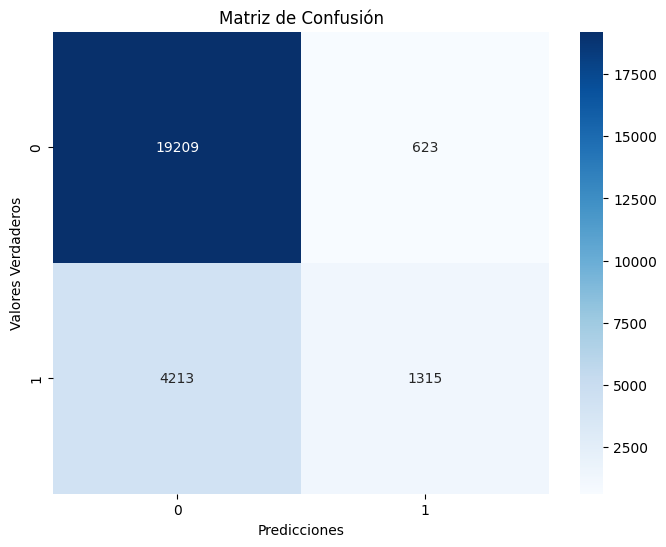

In [258]:
from sklearn.metrics import confusion_matrix

# Calcula la matriz de confusión
confusion = confusion_matrix(y_train, predicciones_cv)

# Crea un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

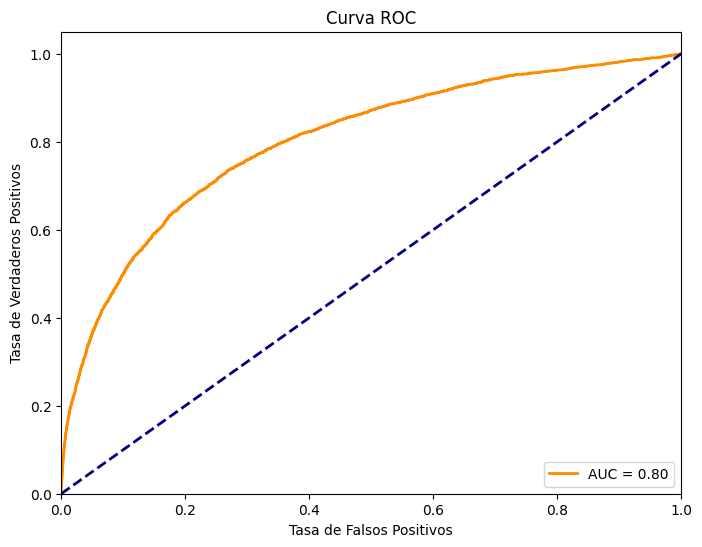

In [259]:
probs = modelo_logit.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, probs)
roc_auc = roc_auc_score(y_train, probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

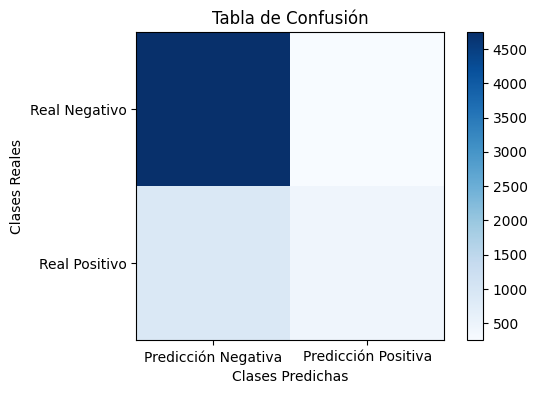

Sensibilidad (Recall): 0.33
Precisión: 0.64


In [260]:
# Calcular la Tabla de Confusión
X_test = sm.add_constant(X_test)
conf_matrix = confusion_matrix(y_test, modelo_logit.predict(X_test))
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
precision = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Tabla de Confusión')
plt.colorbar()
plt.xticks([0, 1], ['Predicción Negativa', 'Predicción Positiva'])
plt.yticks([0, 1], ['Real Negativo', 'Real Positivo'])
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.show()

print(f"Sensibilidad (Recall): {sensitivity:.2f}")
print(f"Precisión: {precision:.2f}")

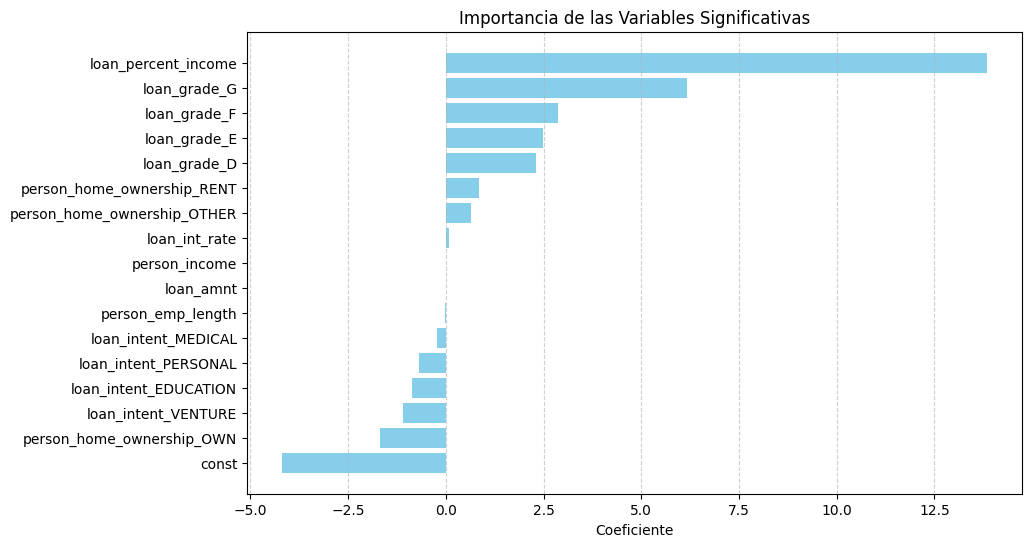

In [200]:
variables_significativas = resultados_df[resultados_df['P-Values'] < 0.05]
variables_significativas = variables_significativas.sort_values(by='Coeficientes', ascending=False)


# Visualizar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.barh(variables_significativas.index, variables_significativas['Coeficientes'], color='skyblue')
plt.xlabel('Coeficiente')
plt.title('Importancia de las Variables Significativas')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # Invierte el eje y para mostrar la variable más importante en la parte superior
plt.show()


In [89]:
for col in data.columns:
        pct_missing = np.sum(data[col].isnull())
        print('{}-{}'.format(col, pct_missing))

person_age-0
person_income-0
person_emp_length-0
loan_amnt-0
loan_int_rate-0
loan_status-0
loan_percent_income-0
cb_person_default_on_file-0
LI_EDUCATION-0
LI_MEDICAL-0
LI_VENTURE-0
LI_PERSONAL-0
LI_HOMEIMPROVEMENT-0
LI_DEBTCONSOLIDATION-0
PHO_OWN-0
PHO_MORTGAGE-0
PHO_RENT-0
PHO_OTHER-0
LG_A-0
LG_B-0
LG_C-0
LG_D-0
LG_E-0
LG_F-0
LG_G-0
CHL_<5-0
5_CHL_10-0
10_CHL_17-0
CHL_>17-0


In [94]:
data['LI_EDUCATION'].value_counts()
data['LI_EDUCATION'].nunique()


2

In [96]:
len(X_train)

26059